In [1]:
import os, gc
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import OpenEXR, Imath
from PIL import Image
from scipy import ndimage
from scipy.stats import skew
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from segment_anything.utils.transforms import ResizeLongestSide
import matplotlib.pyplot as plt

DATASET = "test2"
INPUT_FOLDER = f"./data/{DATASET}"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device.upper()}, Dataset: {DATASET}")

Device: CPU, Dataset: test2


Original: (1526, 858), Edited: (2752, 1536)
Working at: 1526x858


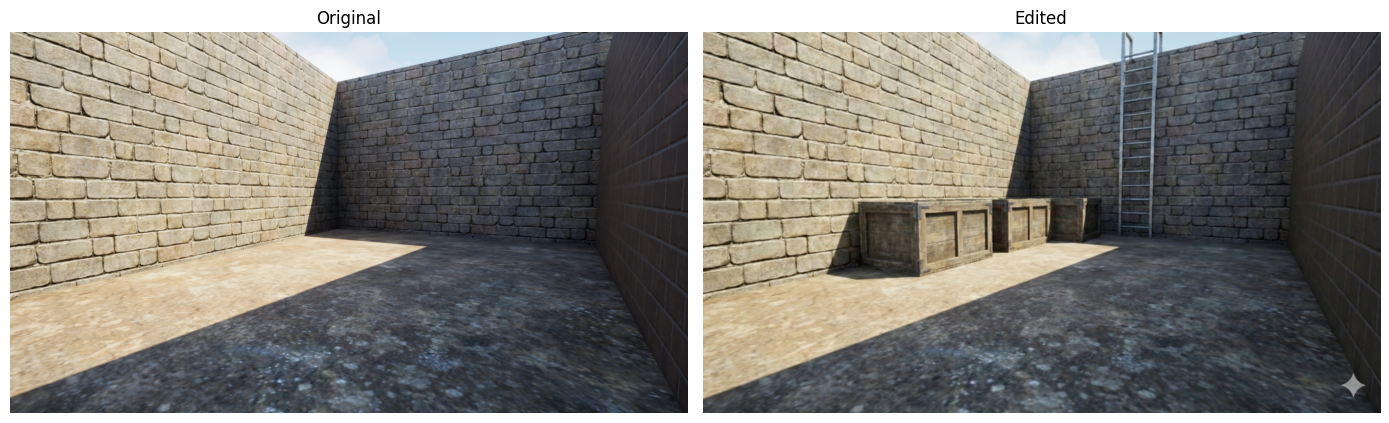

In [2]:
def load_exr_rgb(path):
    exr = OpenEXR.InputFile(path)
    dw = exr.header()['dataWindow']
    w, h = dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    rgb = np.stack([np.frombuffer(exr.channel(c, FLOAT), np.float32).reshape(h, w) for c in 'RGB'], axis=-1)
    return Image.fromarray(np.clip(rgb * 255, 0, 255).astype(np.uint8))

def load_image(path):
    return load_exr_rgb(path) if path.lower().endswith('.exr') else Image.open(path).convert('RGB')

files = os.listdir(INPUT_FOLDER)
gt_rgb_path = next(os.path.join(INPUT_FOLDER, f) for f in files if f.endswith('.exr') and 'depth' not in f.lower() and 'scenedepth' not in f.lower())
edited_path = next(os.path.join(INPUT_FOLDER, f) for f in files if 'edit' in f.lower() and f.endswith(('.png', '.jpg', '.exr')))

original_img = load_image(gt_rgb_path)
edited_img = load_image(edited_path)
edited_resized = edited_img.resize(original_img.size, Image.BILINEAR) if edited_img.size != original_img.size else edited_img
h_img, w_img = np.array(original_img).shape[:2]

print(f"Original: {original_img.size}, Edited: {edited_img.size}")
print(f"Working at: {w_img}x{h_img}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(original_img); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(edited_resized); axes[1].set_title('Edited'); axes[1].axis('off')
plt.tight_layout(); plt.show()

In [3]:
# ── Compute SAM QKV distance map (once, reused by all GeSCF variants) ──
for _v in ('sam', 'hook', 'qkv1', 'qkv2', 'captured'):
    globals().pop(_v, None)
gc.collect(); torch.cuda.empty_cache()

weights_path = "./weights/sam_vit_b_01ec64.pth"
sam = sam_model_registry["vit_b"](checkpoint=weights_path).to(device).eval()

captured = {}
def _hook_qkv(module, input, output):
    captured["qkv"] = output.detach()
hook = sam.image_encoder.blocks[8].attn.qkv.register_forward_hook(_hook_qkv)

img_size = sam.image_encoder.img_size
sam_transform = ResizeLongestSide(img_size)
patch_size = 16
sam_scale = img_size / max(h_img, w_img)
feat_h = int(h_img * sam_scale + 0.5) // patch_size
feat_w = int(w_img * sam_scale + 0.5) // patch_size

def prepare_sam(pil_img):
    t = sam_transform.apply_image(np.array(pil_img))
    return sam.preprocess(torch.as_tensor(t, device=device).permute(2, 0, 1).unsqueeze(0).float())

with torch.no_grad():
    sam.image_encoder(prepare_sam(original_img))
    qkv1 = captured["qkv"]
    sam.image_encoder(prepare_sam(edited_resized))
    qkv2 = captured["qkv"]
hook.remove()
del prepare_sam, _hook_qkv
captured.clear()

with torch.no_grad():
    f1, f2 = qkv1.squeeze(0), qkv2.squeeze(0)
    cos_sim = (F.normalize(f1, dim=-1) * F.normalize(f2, dim=-1)).sum(dim=-1)
    raw_dist = (1 - cos_sim).cpu().numpy()[:feat_h, :feat_w]
del qkv1, qkv2, f1, f2, cos_sim

# Upsample raw distance map to image size (no smoothing yet)
raw_dist_full = F.interpolate(
    torch.tensor(raw_dist)[None, None].float(),
    size=(h_img, w_img), mode='bilinear', align_corners=False
).squeeze().numpy()

# Also compute RGB diff map (pixel-level, for union methods)
arr1 = np.array(original_img).astype(float)
arr2 = np.array(edited_resized).astype(float)
rgb_diff = np.abs(arr1 - arr2).mean(axis=2)

print(f"Feature map: {feat_w}x{feat_h}, raw dist range: {raw_dist.min():.4f} - {raw_dist.max():.4f}")
print(f"RGB diff range: {rgb_diff.min():.1f} - {rgb_diff.max():.1f}")
print("SAM model kept in memory for mask generation")

Feature map: 64x36, raw dist range: 0.0077 - 0.5979
RGB diff range: 0.0 - 213.0
SAM model kept in memory for mask generation


In [4]:
# ── GeSCF parameter sweep ──
# Test combinations of sigma and SAM mask generator settings.
# The distance map is already computed — we just re-smooth and re-threshold.

def make_gescf_mask(raw_dist_full, sam_model, edited_np, sigma, threshold,
                    points_per_side, pred_iou_thresh, stability_score_thresh,
                    min_mask_region_area, overlap_frac):
    """Build a GeSCF mask with given parameters."""
    # Smooth + normalize
    dist = ndimage.gaussian_filter(raw_dist_full, sigma=sigma)
    dmin, dmax = dist.min(), dist.max()
    if dmax - dmin > 1e-8:
        dist = (dist - dmin) / (dmax - dmin)

    # Adaptive threshold if None
    if threshold is None:
        sk = skew(dist.ravel())
        k = np.clip(sk, 1.0, 3.0)
        threshold = dist.mean() + k * dist.std()

    initial_mask = dist > threshold

    # SAM segment-level refinement
    mask_gen = SamAutomaticMaskGenerator(
        sam_model,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        min_mask_region_area=min_mask_region_area,
    )
    sam_masks = mask_gen.generate(edited_np)

    refined = np.zeros_like(initial_mask)
    for seg in sam_masks:
        m = seg["segmentation"]
        if m.sum() > 0 and np.logical_and(m, initial_mask).sum() / m.sum() > overlap_frac:
            refined |= m
    if refined.sum() == 0:
        refined = initial_mask

    return refined, initial_mask, dist, threshold, len(sam_masks)


edited_np = np.array(edited_resized)

# Define parameter sets to test
sweep_configs = {
    "baseline": dict(
        sigma=4, threshold=None,
        points_per_side=16, pred_iou_thresh=0.80,
        stability_score_thresh=0.85, min_mask_region_area=200,
        overlap_frac=0.30,
    ),
    "low_sigma": dict(
        sigma=1.5, threshold=None,
        points_per_side=16, pred_iou_thresh=0.80,
        stability_score_thresh=0.85, min_mask_region_area=200,
        overlap_frac=0.30,
    ),
    "dense_sam": dict(
        sigma=4, threshold=None,
        points_per_side=32, pred_iou_thresh=0.75,
        stability_score_thresh=0.75, min_mask_region_area=50,
        overlap_frac=0.30,
    ),
    "low_overlap": dict(
        sigma=4, threshold=None,
        points_per_side=16, pred_iou_thresh=0.80,
        stability_score_thresh=0.85, min_mask_region_area=200,
        overlap_frac=0.10,
    ),
    "tuned_all": dict(
        sigma=1.5, threshold=None,
        points_per_side=32, pred_iou_thresh=0.75,
        stability_score_thresh=0.75, min_mask_region_area=50,
        overlap_frac=0.10,
    ),
}

sweep_results = {}
for name, cfg in sweep_configs.items():
    print(f"\n--- {name} ---")
    refined, initial, dist, thr, n_segs = make_gescf_mask(
        raw_dist_full, sam, edited_np, **cfg
    )
    sweep_results[name] = {
        "refined": refined, "initial": initial, "dist": dist, "threshold": thr,
    }
    print(f"  sigma={cfg['sigma']}, pts={cfg['points_per_side']}, "
          f"min_area={cfg['min_mask_region_area']}, overlap={cfg['overlap_frac']}")
    print(f"  threshold={thr:.4f}, SAM segments={n_segs}")
    print(f"  initial: {initial.sum():,} px ({initial.mean()*100:.1f}%)")
    print(f"  refined: {refined.sum():,} px ({refined.mean()*100:.1f}%)")

print("\nDone — all variants computed.")


--- baseline ---
  sigma=4, pts=16, min_area=200, overlap=0.3
  threshold=0.5628, SAM segments=65
  initial: 76,235 px (5.8%)
  refined: 103,174 px (7.9%)

--- low_sigma ---
  sigma=1.5, pts=16, min_area=200, overlap=0.3
  threshold=0.5618, SAM segments=65
  initial: 74,760 px (5.7%)
  refined: 103,174 px (7.9%)

--- dense_sam ---
  sigma=4, pts=32, min_area=50, overlap=0.3
  threshold=0.5628, SAM segments=120
  initial: 76,235 px (5.8%)
  refined: 105,265 px (8.0%)

--- low_overlap ---
  sigma=4, pts=16, min_area=200, overlap=0.1
  threshold=0.5628, SAM segments=65
  initial: 76,235 px (5.8%)
  refined: 103,174 px (7.9%)

--- tuned_all ---
  sigma=1.5, pts=32, min_area=50, overlap=0.1
  threshold=0.5618, SAM segments=120
  initial: 74,760 px (5.7%)
  refined: 108,349 px (8.3%)

Done — all variants computed.


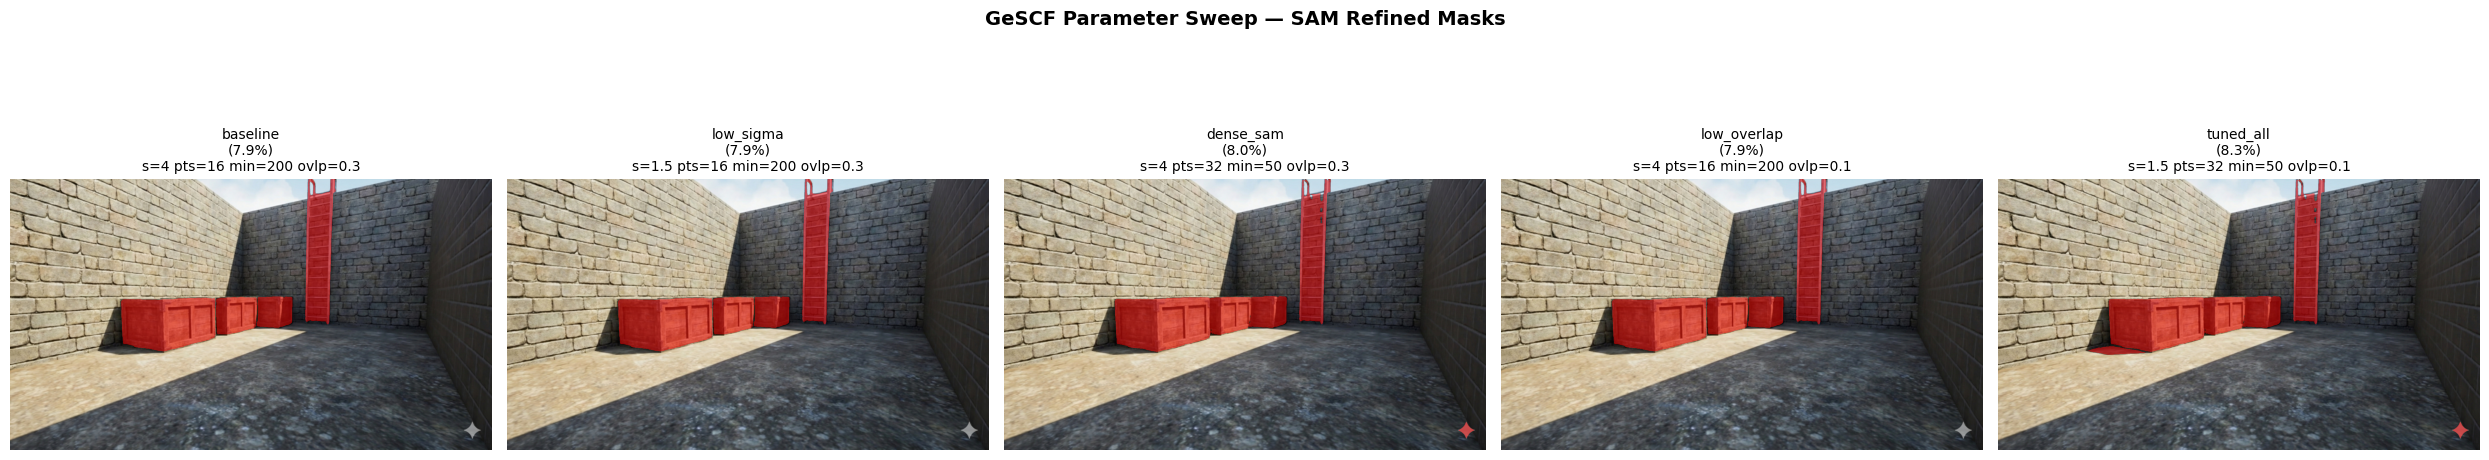

In [11]:
# ── Visualise GeSCF parameter sweep (SAM-refined masks only) ──
names = list(sweep_results.keys())
n = len(names)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))

for i, name in enumerate(names):
    res = sweep_results[name]
    cfg = sweep_configs[name]

    ax = axes[i]
    ax.imshow(edited_resized)
    overlay = np.zeros((*res['refined'].shape, 4))
    overlay[res['refined']] = [1, 0, 0, 0.5]
    ax.imshow(overlay)
    pct = res['refined'].mean() * 100
    ax.set_title(f"{name}\n({pct:.1f}%)\n"
                 f"s={cfg['sigma']} pts={cfg['points_per_side']} "
                 f"min={cfg['min_mask_region_area']} ovlp={cfg['overlap_frac']}", fontsize=10)
    ax.axis('off')

plt.suptitle('GeSCF Parameter Sweep — SAM Refined Masks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# ── Method comparison: different strategies to capture thin structures ──

# Pick the best GeSCF variant as our "tuned" baseline
tuned = sweep_results["tuned_all"]
baseline = sweep_results["baseline"]

# --- Method A: Baseline GeSCF (current pipeline) ---
mask_baseline = baseline["refined"]

# --- Method B: Tuned GeSCF ---
mask_tuned = tuned["refined"]

# --- Method C: Tuned GeSCF + keep initial mask (never lose thin detections) ---
mask_tuned_keep_initial = tuned["refined"] | tuned["initial"]

# --- Method D: Tuned GeSCF + RGB union ---
# RGB at pixel level catches thin colour changes that patches miss
rgb_mask = rgb_diff > 25
# Light refinement: remove tiny noise but keep thin structures
rgb_mask_clean = ndimage.binary_opening(rgb_mask, iterations=1)  # remove 1px noise
# Remove small isolated blobs but keep elongated thin structures
labeled, n_feat = ndimage.label(rgb_mask_clean)
for i in range(1, n_feat + 1):
    if (labeled == i).sum() < 30:  # very small threshold to preserve thin objects
        rgb_mask_clean[labeled == i] = False
mask_union_rgb = tuned["refined"] | rgb_mask_clean

# --- Method E: Tuned GeSCF + initial + RGB union (kitchen sink) ---
mask_all_union = tuned["refined"] | tuned["initial"] | rgb_mask_clean

# --- Method F: Edge-aware boost ---
# Boost distance map values along edges so thin structures pop above threshold
grey = cv2.cvtColor(edited_np, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(grey, 50, 150).astype(float) / 255.0
edges_dilated = ndimage.binary_dilation(edges > 0, iterations=2).astype(float)

# Boost the distance map along edges, then re-threshold
dist_boosted = tuned["dist"] + 0.3 * edges_dilated
dist_boosted = np.clip(dist_boosted, 0, 1)
mask_edge_boost = dist_boosted > tuned["threshold"]
# Clean up: remove tiny noise far from any GeSCF detection
mask_edge_boost = ndimage.binary_opening(mask_edge_boost, iterations=1)

methods = {
    "A: Baseline GeSCF": mask_baseline,
    "B: Tuned GeSCF": mask_tuned,
    "C: Tuned + initial": mask_tuned_keep_initial,
    "D: Tuned + RGB": mask_union_rgb,
    "E: Tuned + init + RGB": mask_all_union,
    "F: Edge boost": mask_edge_boost,
}

for name, m in methods.items():
    print(f"{name:25s}: {m.sum():>8,} px  ({m.mean()*100:.1f}%)")

A: Baseline GeSCF        :  103,174 px  (7.9%)
B: Tuned GeSCF           :  108,349 px  (8.3%)
C: Tuned + initial       :  114,586 px  (8.8%)
D: Tuned + RGB           :  139,921 px  (10.7%)
E: Tuned + init + RGB    :  144,479 px  (11.0%)
F: Edge boost            :  103,907 px  (7.9%)


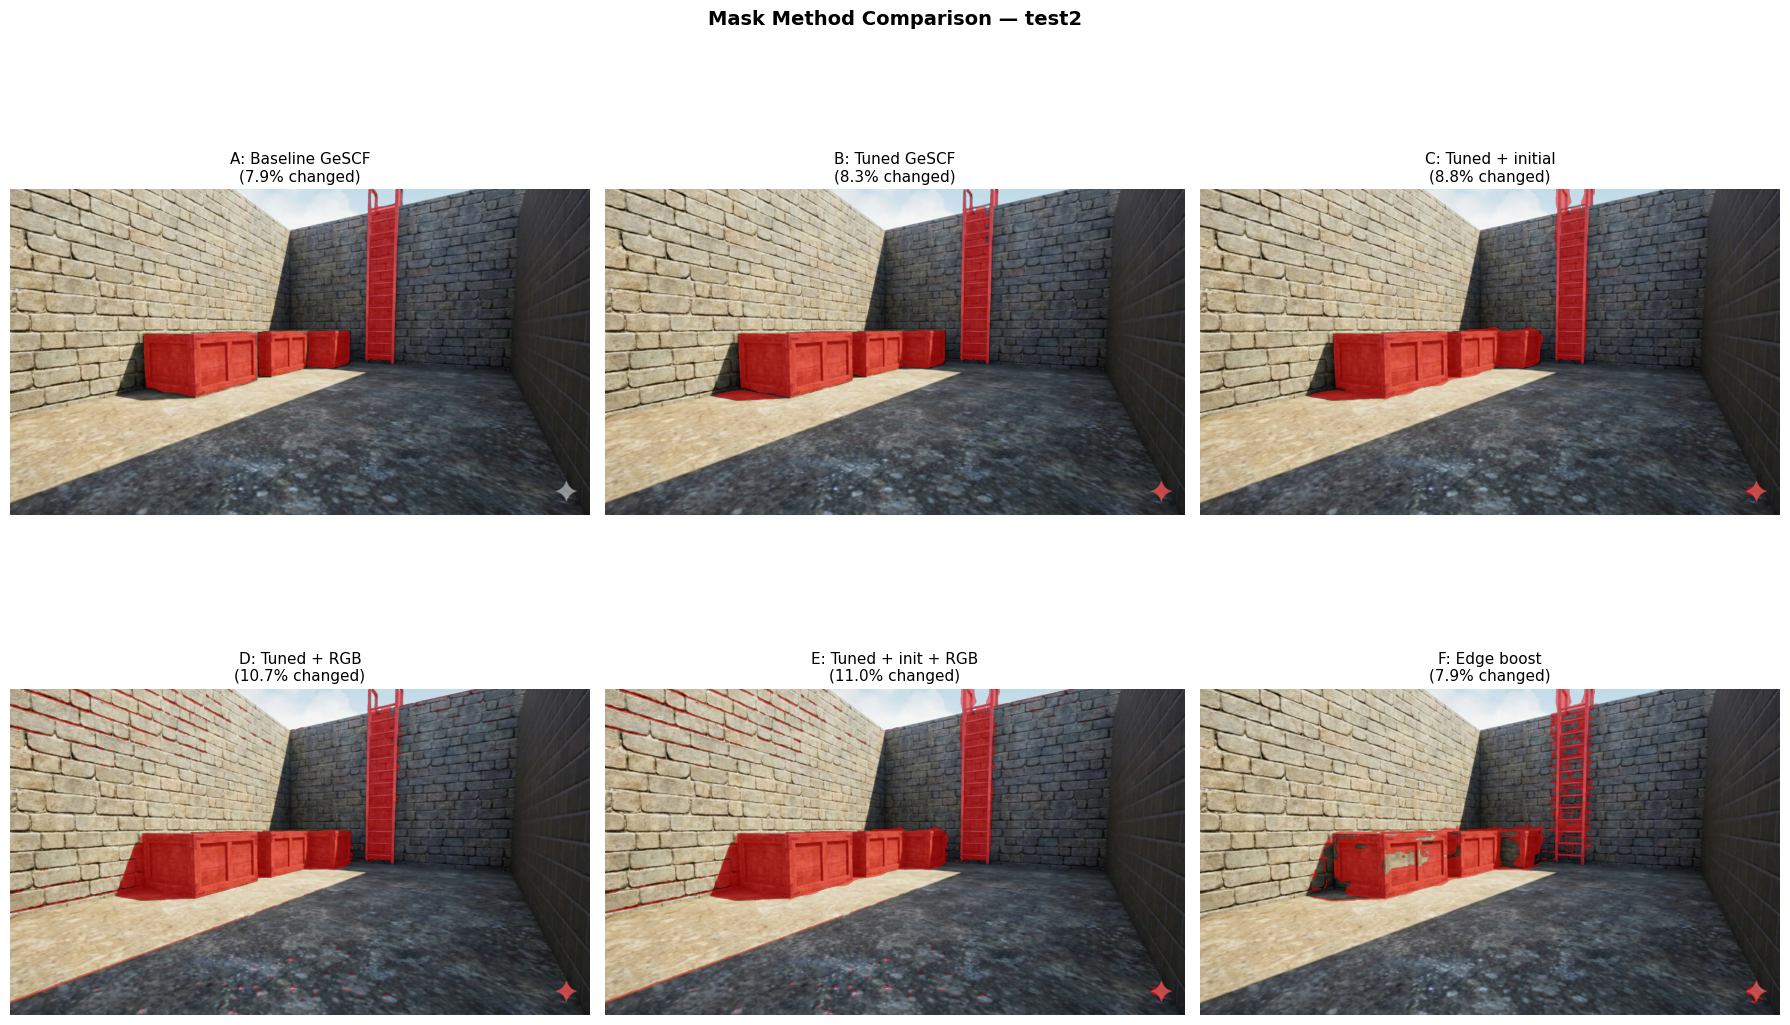

In [13]:
# ── Side-by-side comparison of all methods ──
method_names = list(methods.keys())
n = len(method_names)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, name in enumerate(method_names):
    ax = axes[i]
    mask = methods[name]
    ax.imshow(edited_resized)
    overlay = np.zeros((*mask.shape, 4))
    overlay[mask] = [1, 0, 0, 0.5]
    ax.imshow(overlay)
    pct = mask.mean() * 100
    ax.set_title(f"{name}\n({pct:.1f}% changed)", fontsize=11)
    ax.axis('off')

plt.suptitle(f'Mask Method Comparison — {DATASET}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Zoom region: y=[368:654], x=[74:582] (centred on max disagreement)


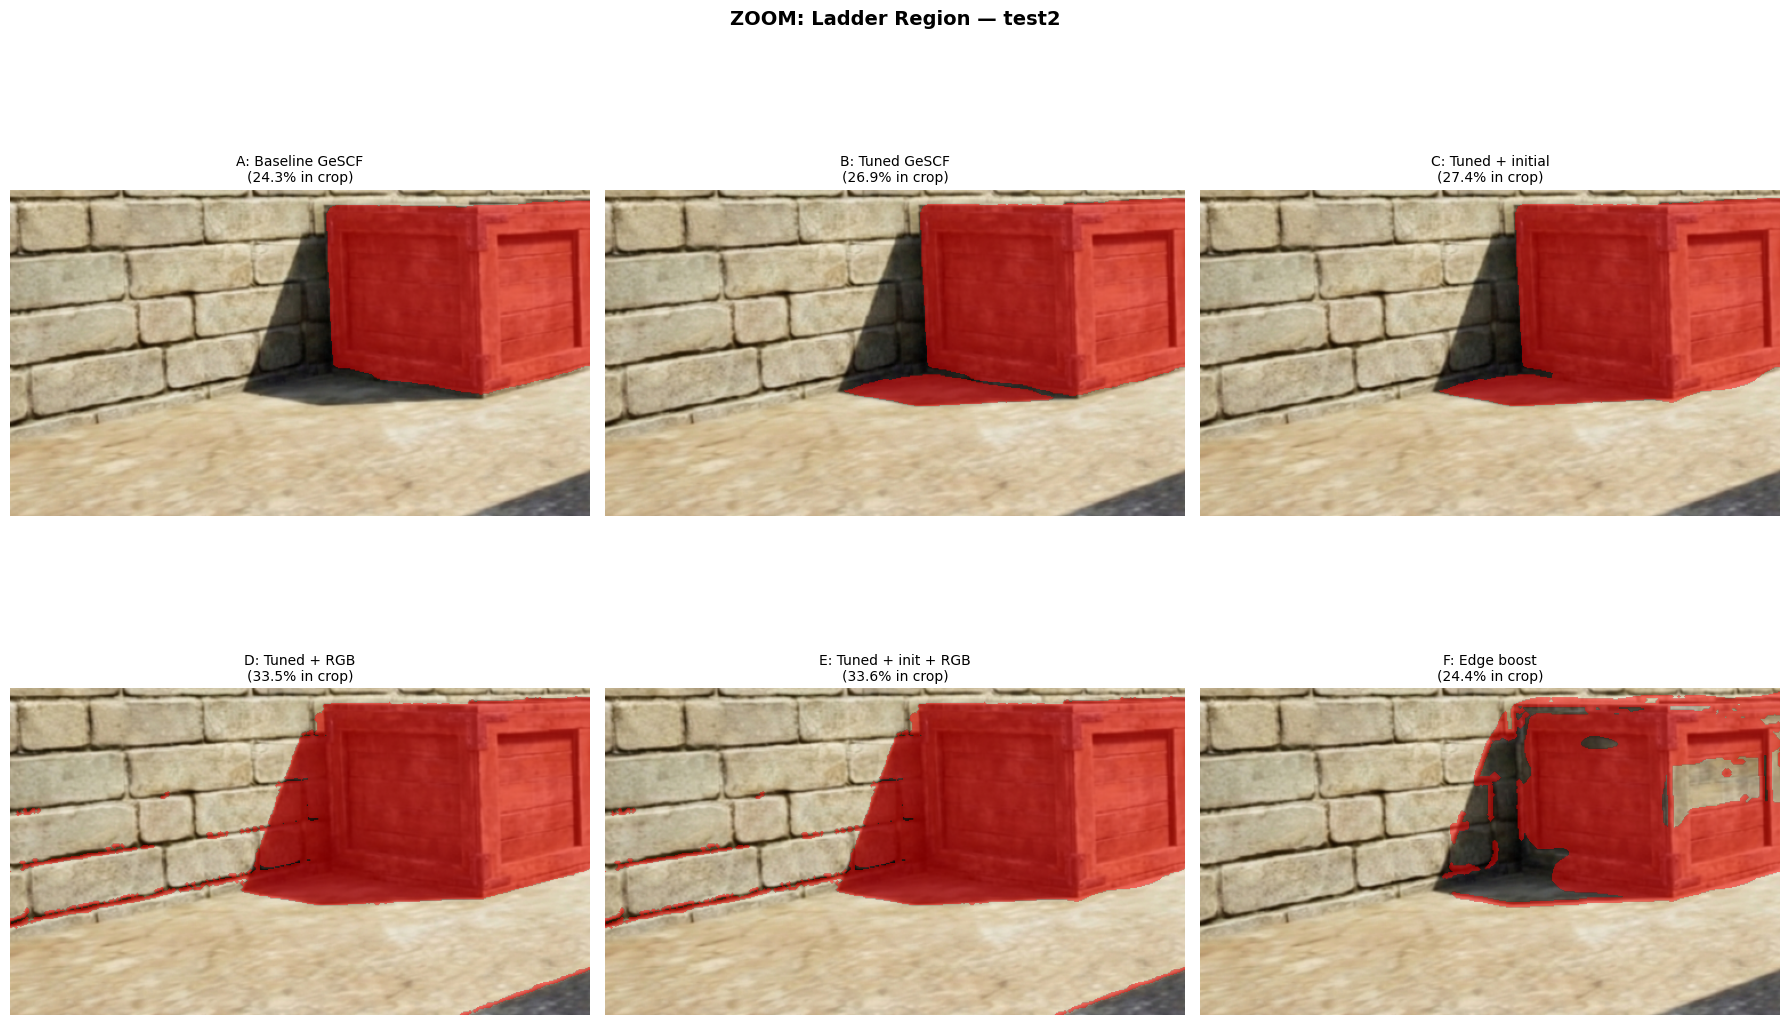

In [14]:
# ── Zoom into the ladder region for detailed comparison ──
# Adjust this crop box to focus on the thin ladder top.
# Format: (y_start, y_end, x_start, x_end) — eyeball from the images above.
# If the ladder isn't in this region, update the coords after seeing the full images.

# Auto-detect: find the region with highest disagreement between methods
# (where baseline misses but others catch)
diff_mask = methods["E: Tuned + init + RGB"].astype(int) - methods["A: Baseline GeSCF"].astype(int)
# Smooth to find the cluster centre
diff_smooth = ndimage.gaussian_filter(diff_mask.astype(float), sigma=30)
peak_y, peak_x = np.unravel_index(diff_smooth.argmax(), diff_smooth.shape)
crop_h, crop_w = h_img // 3, w_img // 3  # crop to ~1/3 of image
y0 = max(0, peak_y - crop_h // 2)
y1 = min(h_img, y0 + crop_h)
x0 = max(0, peak_x - crop_w // 2)
x1 = min(w_img, x0 + crop_w)

print(f"Zoom region: y=[{y0}:{y1}], x=[{x0}:{x1}] (centred on max disagreement)")

method_names = list(methods.keys())
n = len(method_names)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes_flat = axes.flatten()

for i, name in enumerate(method_names):
    ax = axes_flat[i]
    mask = methods[name]
    crop_img = np.array(edited_resized)[y0:y1, x0:x1]
    crop_mask = mask[y0:y1, x0:x1]

    ax.imshow(crop_img)
    overlay = np.zeros((*crop_mask.shape, 4))
    overlay[crop_mask] = [1, 0, 0, 0.5]
    ax.imshow(overlay)
    pct = crop_mask.mean() * 100
    ax.set_title(f"{name}\n({pct:.1f}% in crop)", fontsize=10)
    ax.axis('off')

plt.suptitle(f'ZOOM: Ladder Region — {DATASET}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

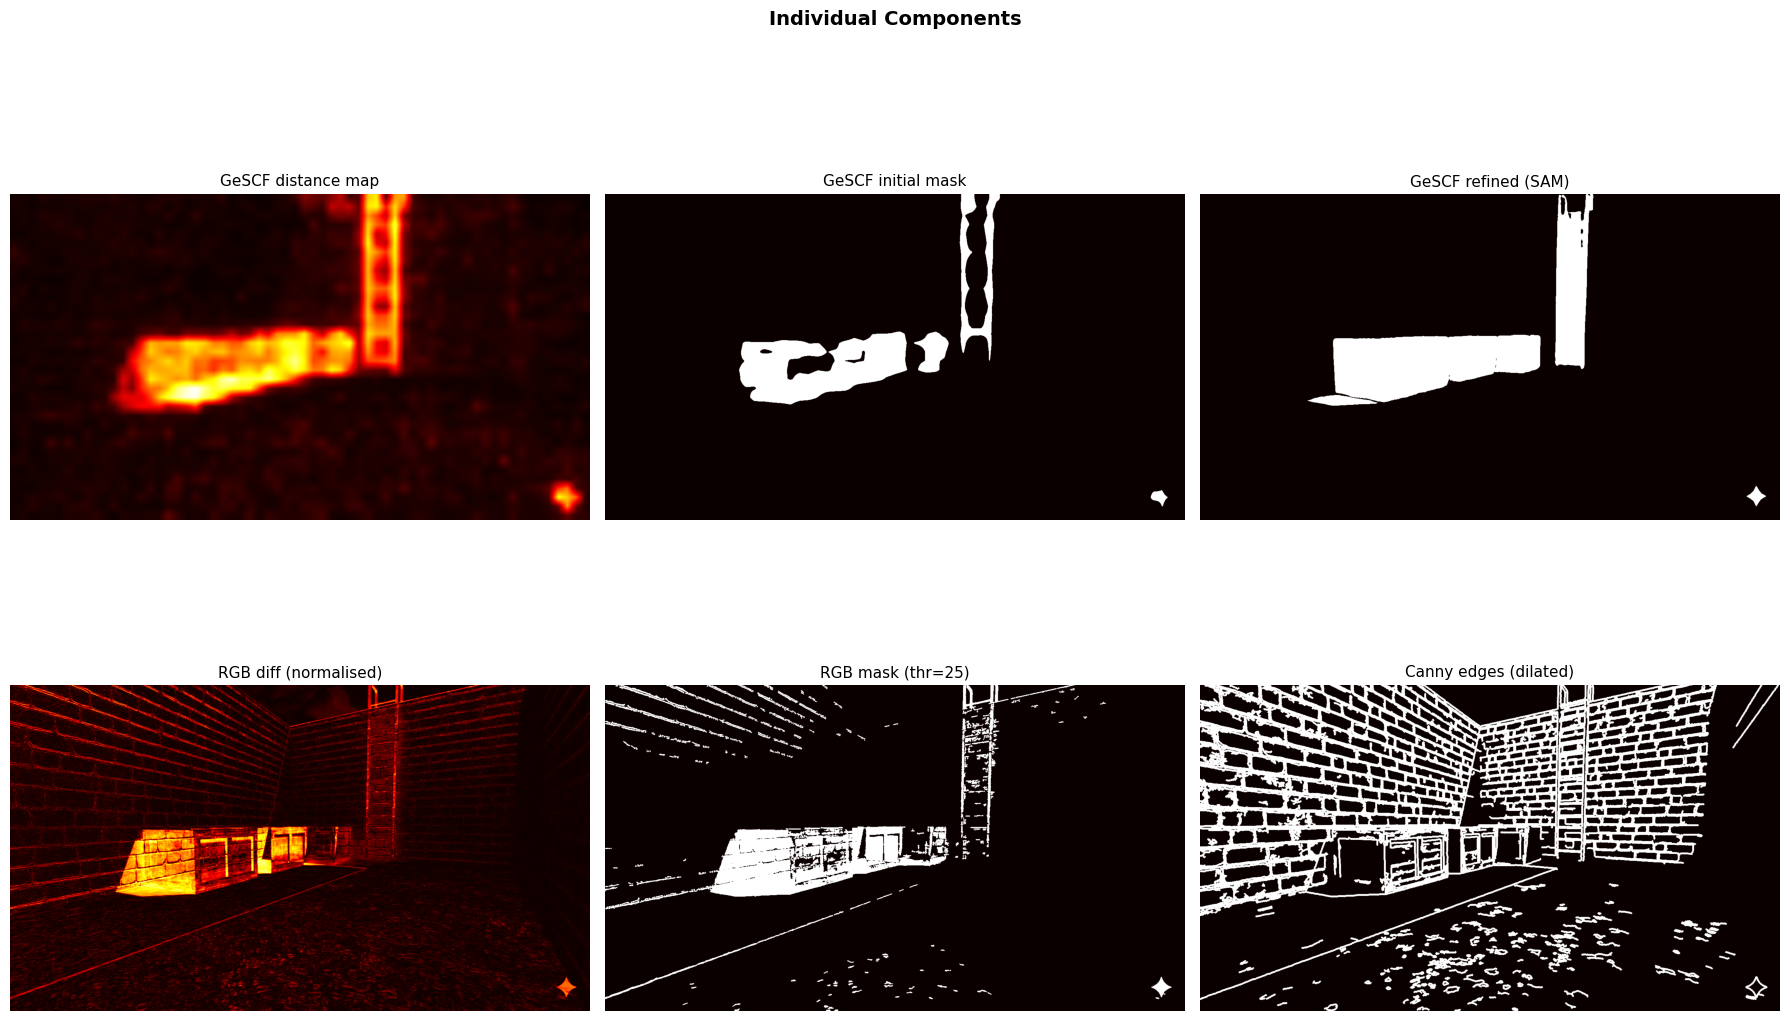

In [9]:
# ── Show what each component contributes ──
# Useful for understanding *why* a method works: what does RGB add? What does
# keeping the initial mask add?

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

components = {
    "GeSCF distance map": tuned["dist"],
    "GeSCF initial mask": tuned["initial"].astype(float),
    "GeSCF refined (SAM)": tuned["refined"].astype(float),
    "RGB diff (normalised)": rgb_diff / max(rgb_diff.max(), 1),
    "RGB mask (thr=25)": rgb_mask_clean.astype(float),
    "Canny edges (dilated)": edges_dilated,
}

for ax, (name, data) in zip(axes.flatten(), components.items()):
    if data.max() <= 1:
        ax.imshow(data, cmap='hot', vmin=0, vmax=1)
    else:
        ax.imshow(data, cmap='hot')
    ax.set_title(name, fontsize=11)
    ax.axis('off')

plt.suptitle('Individual Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# ── Cleanup ──
del sam
gc.collect()
torch.cuda.empty_cache()
print(f"GPU memory: {torch.cuda.memory_allocated()/1e6:.1f} MB")

GPU memory: 0.0 MB
